In [1]:
# Script completo: KDM Regression (Concrete Compressive Strength)
!pip install ucimlrepo

import numpy as np
import keras
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Utils Functions ===
def dm2comp(dm):
    return dm[:, :, 0], dm[:, :, 1:]

def pure2dm(psi):
    ones = keras.ops.ones_like(psi[:, :1])
    return keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)

def dm_rbf_loglik(y_true, dm, sigma):
    d = keras.ops.shape(y_true)[-1]
    w, v = dm2comp(dm)
    dist2 = keras.ops.sum((y_true[:, np.newaxis, :] - v) ** 2, axis=-1)
    kern = keras.ops.exp(-dist2 / (2 * sigma ** 2))
    ll = keras.ops.log(keras.ops.einsum('...i,...i->...', w, kern ** 2) + 1e-12)
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return ll - coeff

def dm_rbf_expectation(dm):
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    sigma_adj = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    sq_norms = keras.ops.sum(v ** 2, axis=-1)
    weighted_sq = keras.ops.einsum('...i,...i->...', w, sq_norms)
    means = keras.ops.einsum('...i,...ij->...j', w, v)
    sq_means = keras.ops.sum(means ** 2, axis=-1)
    return (weighted_sq - sq_means) + d * sigma_adj ** 2



In [2]:
# === Kernel & KDM Layers ===
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.add_weight(shape=(), initializer=keras.initializers.Constant(sigma), trainable=trainable)
        self.dim, self.min_sigma = dim, min_sigma
    def call(self, A, B):
        A_norm = keras.ops.sum(A**2, axis=-1)[..., None]
        B_norm = keras.ops.sum(B**2, axis=-1)[None, None, :]
        flat = keras.ops.reshape(A, [-1, keras.ops.shape(A)[2]])
        AB = keras.ops.matmul(flat, keras.ops.transpose(B))
        AB = keras.ops.reshape(AB, [keras.ops.shape(A)[0], keras.ops.shape(A)[1], keras.ops.shape(B)[0]])
        dist2 = keras.ops.clip(A_norm + B_norm - 2 * AB, 0., np.inf)
        self.sigma.assign(keras.ops.clip(self.sigma, self.min_sigma, np.inf))
        return keras.ops.exp(-dist2 / (2 * self.sigma ** 2))
    def log_weight(self):
        s = keras.ops.clip(self.sigma, self.min_sigma, np.inf)
        return -self.dim * keras.ops.log(s + 1e-12) - self.dim * np.log(4 * np.pi)

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, n_comp, generative=0., l1_x=0., **kwargs):
        super().__init__(**kwargs)
        self.kernel, self.dim_x, self.dim_y = kernel, dim_x, dim_y
        self.n_comp, self.generative, self.l1_x = n_comp, generative, l1_x
        self.c_x = self.add_weight((n_comp, dim_x), initializer='random_normal', trainable=True)
        self.c_y = self.add_weight((n_comp, dim_y), initializer=keras.initializers.Constant(np.sqrt(1./dim_y)), trainable=True)
        self.c_w = self.add_weight((n_comp,), initializer=keras.initializers.Constant(1./n_comp), trainable=True)
        self.eps = 1e-12
    def call(self, dm_x):
        w_in, v_in = dm_x[..., 0], dm_x[..., 1:]
        comp_w = keras.ops.abs(self.c_w)
        comp_w /= keras.ops.clip(keras.ops.sum(comp_w), self.eps, np.inf)
        kv = self.kernel(v_in, self.c_x)
        wv = comp_w[None, None, :] * kv**2
        if self.generative:
            proj = keras.ops.einsum('...i,...ij->...', w_in, wv)
            self.add_loss(-self.generative * keras.ops.mean(keras.ops.log(proj + self.eps) + self.kernel.log_weight()))
        wv = keras.ops.maximum(wv, self.eps)
        wv /= keras.ops.sum(wv, axis=2, keepdims=True)
        w_out = keras.ops.einsum('...i,...ij->...j', w_in, wv)
        dm_y = keras.ops.concatenate([w_out[..., None], keras.ops.broadcast_to(self.c_y[None], [keras.ops.shape(w_out)[0], self.n_comp, self.dim_y])], axis=2)
        return dm_y

class KDMRegressModel(keras.Model):
    def __init__(self, encoded_size, dim_y, encoder, n_comp, sigma_x=0.1, min_sigma_x=1e-3, sigma_y=0.1, min_sigma_y=1e-3, generative=0., entropy_reg_x=0., sigma_x_trainable=True, sigma_y_trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder, self.dim_y, self.n_comp = encoder, dim_y, n_comp
        if generative > 0: encoder.trainable = False
        self.kernel = RBFKernelLayer(sigma_x, encoded_size, trainable=sigma_x_trainable, min_sigma=min_sigma_x)
        self.kdm = KDMLayer(self.kernel, encoded_size, dim_y, n_comp, generative=generative, l1_x=entropy_reg_x)
        self.sigma_y = self.add_weight(shape=(), initializer=keras.initializers.Constant(sigma_y), trainable=sigma_y_trainable)
        self.min_sigma_y = min_sigma_y
    def call(self, x):
        dm_x = pure2dm(self.encoder(x))
        dm_y = self.kdm(dm_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y, self.min_sigma_y, np.inf))
        return dm_y
    def loglik(self, y_true, y_pred):
        return -keras.ops.mean(dm_rbf_loglik(y_true, y_pred, self.sigma_y))
    def predict_reg(self, x, **kwargs):
        dm_y = self.predict(x, **kwargs)
        return keras.ops.convert_to_numpy(dm_rbf_expectation(dm_y)), keras.ops.convert_to_numpy(dm_rbf_variance(dm_y, self.sigma_y))
    def get_sigmas(self):
        return keras.ops.convert_to_numpy(self.kernel.sigma), keras.ops.convert_to_numpy(self.sigma_y)
    def init_components(self, X, Y, init_sigma=False, sigma_mult=1):
        enc = self.encoder.predict(X)
        if init_sigma:
            d, _ = NearestNeighbors(n_neighbors=3).fit(enc).kneighbors(enc)
            self.kernel.sigma.assign(d[:, 2].mean() * sigma_mult)
        self.kdm.c_x.assign(enc)
        self.kdm.c_y.assign(Y)
        self.kdm.c_w.assign(keras.ops.ones((self.n_comp,)) / self.n_comp)



In [3]:
# === Carga y preprocesado ===
from ucimlrepo import fetch_ucirepo
ccs = fetch_ucirepo(id=165)
X = ccs.data.features.values
Y = ccs.data.targets.values.reshape(-1, 1)
# Escaladores guardados
dsc_X = StandardScaler()
dsc_Y = StandardScaler()
X = dsc_X.fit_transform(X)
Y = dsc_Y.fit_transform(Y)
# Split train/val
tX, vX, tY, vY = train_test_split(X, Y, test_size=0.2, random_state=42)
encoded_size, dim_y = tX.shape[1], tY.shape[1]



In [11]:
# === Definición y entrenamiento con mejores hiperparámetros ===
n_comp = 30
enc = keras.Sequential([keras.layers.Identity()])
model = KDMRegressModel(
    encoded_size,
    dim_y,
    enc,
    n_comp,
    sigma_x=0.8,
    min_sigma_x=1e-3,
    sigma_y=0.4,
    min_sigma_y=1e-3,
    generative=0.0
)
model.compile(
    optimizer=optimizers.Adam(5e-3),
    loss=model.loglik
)
# Early stopping
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Inicializa prototipos
idx = np.random.RandomState(42).randint(tX.shape[0], size=n_comp)
model.init_components(tX[idx], tY[idx])

# Entrenamiento
hist = model.fit(
    tX,
    tY,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early],
    verbose=1
)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.5428 - val_loss: 1.4744
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1389 - val_loss: 1.2567
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9708 - val_loss: 1.1872
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0117 - val_loss: 1.1124
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9164 - val_loss: 1.0571
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8392 - val_loss: 1.0219
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8657 - val_loss: 0.9695
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7911 - val_loss: 0.9611
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7970 - val_loss: 0.9145
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7547 - val_loss: 0.9010
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7655 - val_loss: 0.8883
Epoch 12/100
24/24 ━━━━━

In [12]:
# === Métricas finales ===
# Sigmas aprendidos
sigma_x_learned, sigma_y_learned = model.get_sigmas()
print(f"Sigma_x aprendido: {sigma_x_learned:.4f}")
print(f"Sigma_y aprendido: {sigma_y_learned:.4f}")

# Predicción en set de validación y reescalado
y_pred, y_var = model.predict_reg(vX)
y_pred_res = dsc_Y.inverse_transform(y_pred)
y_true_res = dsc_Y.inverse_transform(vY)

# MSE y R2
mse = mean_squared_error(y_true_res, y_pred_res)
r2  = r2_score(y_true_res, y_pred_res)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 : {r2:.4f}")



Sigma_x aprendido: 0.6560
Sigma_y aprendido: 0.4355
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Test MSE: 61.2211
Test R2 : 0.7624


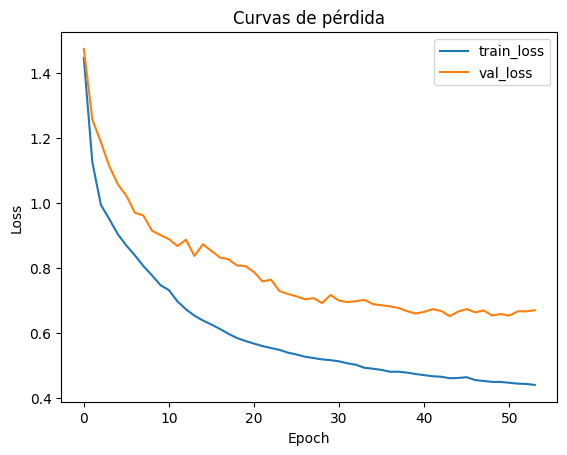

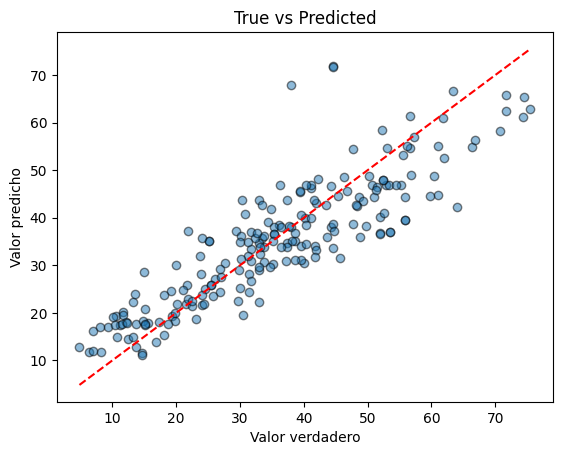

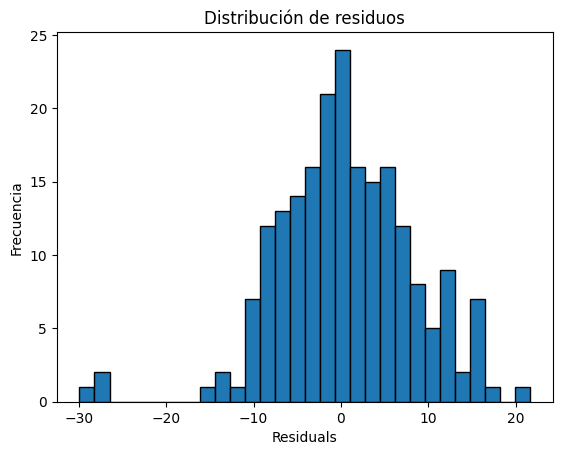

In [13]:
# === Visualizaciones ===
plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curvas de pérdida')
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_true_res, y_pred_res, alpha=0.5, edgecolor='k')
lims = [y_true_res.min(), y_true_res.max()]
plt.plot(lims, lims, 'r--')
plt.xlabel('Valor verdadero')
plt.ylabel('Valor predicho')
plt.title('True vs Predicted')
plt.show()

plt.figure()
res = y_true_res - y_pred_res
plt.hist(res.flatten(), bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frecuencia')
plt.title('Distribución de residuos')
plt.show()